In [1]:
train_data = '/mnt/dataset/train-valid_set'
inference_data = '/mnt/dataset/test_set'

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math

file_list = os.listdir(train_data)

In [3]:
class_list = ['Prograsp (da Vinci) (GRSR-UCDV)',
              'R-LND (da Vinci) (NDDR-LADV)',
              'R-Maryland (da Vinci) (BFCR-MADV)',
              'R-Scissors (da Vinci) (MSCR-UCDV)',
              'Suction Irrigator (SIRL-UCUK)',
              'Graspers (straight) (OLYMPUS) (GRSL-UCOL)',
              'Needle Holder (AESCULAP) (NDHL-UCAE)',
              'Metal Clip Applier (Medtronic) (CLAL-M3MT)',
              'Polymer Clip Applier (CLAL-UCUK)'
             ]

In [4]:
import json

def getjson(json_path):
    with open(json_path) as json_file:
        json_data = json.load(json_file)
    return json_data

In [5]:
# 근데 이미지 하나당 수술도구 하나씩 나오니까
# 처음부터 데이터를 전부 읽어와서 리스트 하나로 만들어봤어

# all_data 는 모든 json file 리스트
# data_dic 는 key 값이 수술도구, value가 json file인 딕셔너리

all_data = []
data_dic = {}

for tool in file_list:
    files = os.listdir(train_data+'/'+tool)
    json_files = [file for file in files if file.endswith(".json")]
    
    all_data.extend(json_files)
    data_dic[tool] = json_files

len(all_data) # 모든 json file은 12408개

12408

In [6]:
all_data = list(set(all_data))
len(all_data)

10792

In [7]:
# all_dic 은 key 값은 사진, value값은 수술도구인 딕셔너리.
# 만들기 어려웠음! #수고했음!
# 이렇게 하면 사진 하나에서 여러 어노테이션을 동시에 볼 수 있음.

all_dic = {}
        
for files in all_data:
    for i in data_dic:
        if(files in data_dic[i]):
            if(files in all_dic):
                temp = all_dic[files]
                temp.append(i)
                all_dic[files] = temp
            else:
                all_dic[files] = [i]
all_dic

{'SNUH_DC07_JCW0_RALP_0008_00082302.json': ['Metal Clip Applier (Medtronic) (CLAL-M3MT)'],
 'SNUH_DC08_KHS0_ENME_0039_00062829.json': ['R-Scissors (da Vinci) (MSCR-UCDV)'],
 'SNUH_DC07_JCW0_RLPN_0002_0074480.json': ['R-Scissors (da Vinci) (MSCR-UCDV)'],
 'SNUH_DC07_JCW0_RALP_0031_00098923.json': ['Graspers (straight) (OLYMPUS) (GRSL-UCOL)'],
 'SNUH_DC07_JCW0_RLPN_0003_0059922.json': ['Prograsp (da Vinci) (GRSR-UCDV)'],
 'SNUH_DC08_KHS0_ENME_0020_0031596.json': ['Suction Irrigator (SIRL-UCUK)'],
 'SNUH_DC07_JCW0_RALP_0002_00034471.json': ['Metal Clip Applier (Medtronic) (CLAL-M3MT)'],
 'SNUH_DC07_JCW0_RALP_0000_0015845.json': ['Suction Irrigator (SIRL-UCUK)',
  'R-Scissors (da Vinci) (MSCR-UCDV)',
  'R-Maryland (da Vinci) (BFCR-MADV)'],
 'SNUH_DC07_JCW0_RLPN_0003_0041371.json': ['R-Scissors (da Vinci) (MSCR-UCDV)',
  'R-Maryland (da Vinci) (BFCR-MADV)'],
 'SNUH_DC07_JCW0_RLPN_0002_0094855.json': ['R-Scissors (da Vinci) (MSCR-UCDV)',
  'Prograsp (da Vinci) (GRSR-UCDV)'],
 'SNUH_DC07_JCW0

In [8]:
data_filenames = list(all_dic.keys())
data_filenames.sort()

In [88]:
from PIL import Image, ImageDraw

def getData(file):
    tools = all_dic[file]

    json_path = train_data + '/' + tools[0] + '/' + file
    json_data = getjson(json_path)
    width = json_data['images']['width']
    height = json_data['images']['height']
    
    image_path = train_data+'/'+tools[0]+'/'+ file.rpartition('.')[0]+'.png'
    mask = np.expand_dims(np.load('data/'+file.rpartition('.')[0]+'.npy'),-1)
    '''
    mask = np.zeros((height,width,9))
    for tool in tools:
        class_num = class_list.index(tool)
        json_path = train_data + '/' + tool + '/' + file
        json_data = getjson(json_path)
        for classes in class_list:
            for json_seg in json_data['annotations']:
                if(classes == json_seg['category_name']):
                    found = True
                    points = json_seg["points"].copy()
                    points.append(points[0])
                    points = [(x[0],x[1]) for x in points]
                    img = Image.new('L', (width, height), 0)
                    ImageDraw.Draw(img).polygon(points, outline=1, fill=1)
                    mask[:,:,class_num] = np.array(img)
    np.save('data/'+file.rpartition('.')[0], mask)
    '''

    return image_path, mask

In [117]:
def _process_pathnames(filename):
    # We map this function onto each pathname pair
    fname, labels = getData(filename)
    
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_png(img_str, channels=3) # RGB
    
    label_img = tf.convert_to_tensor(labels)
    width = tf.cast(label_img.shape[0], dtype=tf.uint16)
    height = tf.cast(label_img.shape[1], dtype=tf.uint16)
    
    resize = [288, 512]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)
    
    label_cls = [int(tf.cast(label_img==i, dtype=tf.uint8).numpy().sum()>0) for i in range(1,10)]
    label_cls = tf.cast(tf.convert_to_tensor(label_cls), dtype=tf.float32)
    
    label_img = [tf.cast(label_img==i, dtype=tf.uint8).numpy() for i in range(1,10)]
    label_img = tf.concat(label_img,axis=-1)
    
    #label_cls = tf.reduce_sum(label_img,[0,1])>0
    #label_cls = tf.cast(label_cls, dtype=tf.float32)
    
    scale = 1 / 255.                
    img = tf.cast(img, dtype=tf.float32) * scale
    filename = tf.cast(filename, dtype=tf.string)
    
    return filename, width, height, img, label_img, label_cls

In [118]:
from sklearn.model_selection import train_test_split

val_ratio = 0.2
seed = 1234

train_filenames, test_filenames = train_test_split(data_filenames,
                                                   test_size=val_ratio,
                                                   random_state=seed,
                                                  )

num_train_examples = len(train_filenames)
num_test_examples = len(test_filenames)

In [119]:

import tensorflow as tf
import tensorflow_addons as tfa

img_shape = (288, 512, 3)
    
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],  
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

def flip_img(horizontal_flip, vertically_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)), 
                                lambda: (tr_img, label_img))
    if vertically_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)), 
                                lambda: (tr_img, label_img))
    return tr_img, label_img


def rotate_img(tr_img, label_img):
    rotate_prob = tf.random.uniform([], 0.0, 1.0)
    degrees = tf.random.uniform([], -45, 45)
    tr_img, label_img = tf.cond(tf.less(rotate_prob, 0.5),
                            lambda: (tfa.image.rotate(tr_img, degrees * math.pi / 180, interpolation = 'BILINEAR', fill_mode= 'reflect'), tfa.image.rotate(label_img, degrees * math.pi / 180, interpolation = 'BILINEAR' , fill_mode= 'reflect')), 
                            lambda: (tr_img, label_img))
    return tr_img, label_img



In [120]:
def _augment(filename, width, height, img, label_img, label_cls,
             resize=None,    # Resize the image to some size e.g. [256, 256]
             scale=1,    # Scale image e.g. 1 / 255.
             hue_delta=0.01,
             horizontal_flip=True,    # Random left right flip,
             vertically_flip=True,    # Random up down flip,
             width_shift_range=.1,    # Randomly translate the image horizontally
             height_shift_range=.1):    # Randomly translate the image vertically
    
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
    
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
    
    img, label_img = flip_img(horizontal_flip, vertically_flip, img, label_img)                               
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)                      
    img, label_img = rotate_img(img, label_img)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return filename, width, height, img, label_img, label_cls

In [123]:
import functools
    
batch_size = 8
max_epochs = 20
    
def gen_train():
    for i in train_filenames:
        yield _process_pathnames(i)
    
def gen_test():
    for i in test_filenames:
        yield _process_pathnames(i)
    
def get_dataset(preproc_fn = functools.partial(_augment),
                 threads = 6,
                 batch_size = batch_size,
                 is_train = True):
    
    if is_train:
        dataset = tf.data.Dataset.from_generator(gen_train, (tf.string, tf.uint16, tf.uint16, tf.float32, tf.float32, tf.float32), ((), (), (), (288,512,3), (288,512,9), (9)))
    else:
        dataset = tf.data.Dataset.from_generator(gen_test, (tf.string, tf.uint16, tf.uint16, tf.float32, tf.float32, tf.float32), ((), (), (), (288,512,3), (288,512,9), (9)))
    
    if is_train:
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    dataset = dataset.batch(batch_size)
        
    return dataset

In [124]:
train_dataset = get_dataset(is_train=True)
test_dataset = get_dataset(is_train=False)

In [125]:
print(train_dataset)

<BatchDataset shapes: ((None,), (None,), (None,), (None, 288, 512, 3), (None, 288, 512, 9), (None, 9)), types: (tf.string, tf.uint16, tf.uint16, tf.float32, tf.float32, tf.float32)>


In [13]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses

In [14]:
class Conv(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.dropout(x)
        x = layers.ReLU()(x)

        return x

In [15]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs):
        conv_block = self.conv1(inputs)
        conv_block = self.conv2(conv_block)

        return conv_block

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.Conv2D(num_filters, 3, padding='same', strides=2, activation='relu', kernel_initializer='he_normal')
        # layers.MaxPool2D((2,2))

    def call(self, inputs):
        encoder = self.conv_block(inputs)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder                                         


class DecoderBlock(tf.keras.layers.Layer):                                         
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()
        self.conv_block = ConvBlock(num_filters)

    def call(self, input_tensor, concat_tensor):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder)
        decoder = layers.ReLU()(decoder)
        decoder = layers.concatenate([decoder,concat_tensor]) # tf.concat([decoder, concat_tensor], -1)
        decoder = self.conv_block(decoder)

        return decoder

In [16]:
import tensorflow as tf
initializer = tf.keras.initializers.HeNormal()

In [21]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.encoder_block0 = EncoderBlock(16)
        self.encoder_block1 = EncoderBlock(32)
        self.encoder_block2 = EncoderBlock(64)
        self.encoder_block3 = EncoderBlock(128)
        self.encoder_block4 = EncoderBlock(256)
        
        self.center = ConvBlock(512)
        
        self.flatten = tf.keras.layers.Flatten()
        self.output_linear = tf.keras.layers.Dense(9, activation='sigmoid', kernel_initializer='glorot_uniform')
        
        self.decoder_block4 = DecoderBlock(256)
        self.decoder_block3 = DecoderBlock(128)
        self.decoder_block2 = DecoderBlock(64) 
        self.decoder_block1 = DecoderBlock(32)  
        self.decoder_block0 = DecoderBlock(16)

        self.output_conv = layers.Conv2D(9, 1, padding='same', activation='sigmoid', kernel_initializer='glorot_uniform' )

    def call(self, inputs):
        encoder0_pool, encoder0_skip = self.encoder_block0(inputs)
        encoder1_pool, encoder1_skip = self.encoder_block1(encoder0_pool)
        encoder2_pool, encoder2_skip = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3_skip = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4_skip = self.encoder_block4(encoder3_pool)
        
        center = self.center(encoder4_pool)
        cls = self.output_linear(self.flatten(center))
        
        decoder4 = self.decoder_block4(center,encoder4_skip)
        decoder3 = self.decoder_block3(decoder4,encoder3_skip)
        decoder2 = self.decoder_block2(decoder3,encoder2_skip)
        decoder1 = self.decoder_block1(decoder2,encoder1_skip)
        decoder0 = self.decoder_block0(decoder1, encoder0_skip)

        outputs = self.output_conv(decoder0)
        
        return outputs, cls

In [20]:
model = UNet()
outputs, cls = model(tf.random.normal([8, 288, 512, 3]))
print(outputs.shape, cls.shape)
model.summary()

(8, 288, 512, 9) (8, 9)
Model: "u_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block_12 (EncoderBlo multiple                  5216      
_________________________________________________________________
encoder_block_13 (EncoderBlo multiple                  23392     
_________________________________________________________________
encoder_block_14 (EncoderBlo multiple                  92864     
_________________________________________________________________
encoder_block_15 (EncoderBlo multiple                  370048    
_________________________________________________________________
encoder_block_16 (EncoderBlo multiple                  1477376   
_________________________________________________________________
conv_block_29 (ConvBlock)    multiple                  3544064   
_________________________________________________________________
flatten_2 (Flatten)          multip

In [140]:
import tensorflow as tf
import tensorflow.keras.backend as K

class ConvolutionBnActivation(tf.keras.layers.Layer):
    """
    """
    # def __init__(self, filters, kernel_size, strides=(1, 1), activation=tf.keras.activations.relu, **kwargs):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding="same", data_format=None, dilation_rate=(1, 1),
                 groups=1, activation=None, kernel_initializer="glorot_uniform", bias_initializer="zeros", kernel_regularizer=None,
                 bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, use_batchnorm=False, 
                 axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, trainable=True,
                 post_activation="relu", block_name=None):
        super(ConvolutionBnActivation, self).__init__()


        # 2D Convolution Arguments
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.dilation_rate = dilation_rate
        self.activation = activation
        self.use_bias = not (use_batchnorm)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint

        # Batch Normalization Arguments
        self.axis = axis
        self.momentum = momentum
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.trainable = trainable
        
        self.block_name = block_name
        
        self.conv = None
        self.bn = None
        #tf.keras.layers.BatchNormalization(scale=False, momentum=0.9)
        self.post_activation = tf.keras.layers.Activation(post_activation)

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate,
            activation=self.activation,
            use_bias=self.use_bias,
            kernel_initializer=self.kernel_initializer,
            bias_initializer=self.bias_initializer,
            kernel_regularizer=self.kernel_regularizer,
            bias_regularizer=self.bias_regularizer,
            activity_regularizer=self.activity_regularizer,
            kernel_constraint=self.kernel_constraint,
            bias_constraint=self.bias_constraint,
            name=self.block_name + "_conv" if self.block_name is not None else None

        )

        self.bn = tf.keras.layers.BatchNormalization(
            axis=self.axis,
            momentum=self.momentum,
            epsilon=self.epsilon,
            center=self.center,
            scale=self.scale,
            trainable=self.trainable,
            name=self.block_name + "_bn" if self.block_name is not None else None
        )

    def call(self, x, training=None):
        x = self.conv(x)
        x = self.bn(x, training=training)
        x = self.post_activation(x)

        return x

    def compute_output_shape(self, input_shape):
        print(input_shape)
        return [input_shape[0], input_shape[1], input_shape[2], self.filters]

In [141]:
class AtrousSeparableConvolutionBnReLU(tf.keras.layers.Layer):

    def __init__(self, filters, kernel_size, strides=[1, 1, 1, 1], padding="SAME", data_format=None,
                 dilation=None, channel_multiplier=1, axis=-1, momentum=0.99, epsilon=0.001,
                 center=True, scale=True, trainable=True, post_activation=None, block_name=None):
        super(AtrousSeparableConvolutionBnReLU, self).__init__()

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.dilation = dilation
        self.channel_multiplier = channel_multiplier

        # Batch Normalization Arguments
        self.axis = axis
        self.momentum = momentum
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.trainable = trainable
        
        self.block_name = block_name
        
        self.bn = None

        self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
        
        self.dw_filter = None
        self.pw_filter = None

    def build(self, input_shape):
        in_channels = input_shape[-1]
        self.dw_filter = self.add_weight(
            name="dw_kernel",
            shape=[self.kernel_size, self.kernel_size, in_channels, self.channel_multiplier],
            initializer=tf.keras.initializers.GlorotNormal(),
            regularizer=tf.keras.regularizers.l2(l=1e-4),
            trainable=True
        )
        self.pw_filter = self.add_weight(
            name="pw_kernel",
            shape=[1, 1, in_channels * self.channel_multiplier, self.filters],
            initializer=tf.keras.initializers.GlorotNormal(),
            regularizer=tf.keras.regularizers.l2(l=1e-4),
            trainable=True
        )

        self.bn = tf.keras.layers.BatchNormalization(
            axis=self.axis,
            momentum=self.momentum,
            epsilon=self.epsilon,
            center=self.center,
            scale=self.scale,
            name=self.block_name + "_bn" if self.block_name is not None else None
        )
        
    def call(self, x, training=None):
        x = tf.nn.separable_conv2d(
            x,
            self.dw_filter,
            self.pw_filter,
            strides=self.strides,
            dilations=[self.dilation, self.dilation],
            padding=self.padding,
            )
        x = self.bn(x, training=training)
        x = self.activation(x)

        return x

    def compute_output_shape(self, input_shape):
        print(input_shape)
        return [input_shape[0], input_shape[1], input_shape[2], self.filters]

In [142]:
class AtrousSpatialPyramidPoolingV3(tf.keras.layers.Layer):
    def __init__(self, atrous_rates, filters):
        super(AtrousSpatialPyramidPoolingV3, self).__init__()
        self.filters = filters

        # adapt scale and mometum for bn
        self.conv_bn_relu = ConvolutionBnActivation(filters=filters, kernel_size=1)

        self.atrous_sepconv_bn_relu_1 = AtrousSeparableConvolutionBnReLU(dilation=atrous_rates[0], filters=filters, kernel_size=3)
        self.atrous_sepconv_bn_relu_2 = AtrousSeparableConvolutionBnReLU(dilation=atrous_rates[1], filters=filters, kernel_size=3)
        self.atrous_sepconv_bn_relu_3 = AtrousSeparableConvolutionBnReLU(dilation=atrous_rates[2], filters=filters, kernel_size=3)

        # 1x1 reduction convolutions
        self.conv_reduction_1 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=1,
            use_bias=False,
            kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))


    def call(self, input_tensor, training=None):
        # global average pooling input_tensor
        glob_avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2], keepdims=True))(input_tensor)
        glob_avg_pool = self.conv_bn_relu(glob_avg_pool, training=training)
        glob_avg_pool = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [input_tensor.shape[1], input_tensor.shape[2]]))(glob_avg_pool)

        # process with atrous
        w = self.conv_bn_relu(input_tensor, training=training)
        x = self.atrous_sepconv_bn_relu_1(input_tensor, training=training)
        y = self.atrous_sepconv_bn_relu_2(input_tensor, training=training)
        z = self.atrous_sepconv_bn_relu_3(input_tensor, training=training)

        # concatenation
        net = tf.concat([glob_avg_pool, w, x, y, z], axis=-1)
        net = self.conv_reduction_1(net, training=training)

        return net

    def compute_output_shape(self, input_shape):
        print(input_shape)
        return [input_shape[0], input_shape[1], input_shape[2], 256]

In [143]:
def create_base_model(name="ResNet50", weights="imagenet", height=None, width=None,
                      channels=3, include_top=False, pooling=None, alpha=1.0,
                      depth_multiplier=1, dropout=0.001):
    if not isinstance(height, int) or not isinstance(width, int) or not isinstance(channels, int):
        raise TypeError("'height', 'width' and 'channels' need to be of type 'int'")
        
    if channels <= 0:
        raise ValueError(f"'channels' must be greater of equal to 1 but given was {channels}")
    
    input_shape = [height, width, channels]

    if name.lower() == "densenet121":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.DenseNet121(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1/relu", "pool2_relu", "pool3_relu", "pool4_relu", "relu"]
    elif name.lower() == "densenet169":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.DenseNet169(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1/relu", "pool2_relu", "pool3_relu", "pool4_relu", "relu"]
    elif name.lower() == "densenet201":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.DenseNet201(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1/relu", "pool2_relu", "pool3_relu", "pool4_relu", "relu"]
    elif name.lower() == "efficientnetb0":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB0(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb1":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB1(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb2":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB2(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb3":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB3(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb4":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB4(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb5":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB5(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb6":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB6(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "efficientnetb7":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.EfficientNetB7(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation", "top_activation"]
    elif name.lower() == "mobilenet":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.MobileNet(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling, alpha=alpha, depth_multiplier=depth_multiplier, dropout=dropout)
        layer_names = ["conv_pw_1_relu", "conv_pw_3_relu", "conv_pw_5_relu", "conv_pw_11_relu", "conv_pw_13_relu"]
    elif name.lower() == "mobilenetv2":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.MobileNetV2(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling, alpha=alpha)
        layer_names = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu", "out_relu"]
    elif name.lower() == "nasnetlarge":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.NASNetLarge(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["zero_padding2d", "cropping2d_1", "cropping2d_2", "cropping2d_3", "activation_650"]
    elif name.lower() == "nasnetmobile":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.NASNetMobile(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names =["zero_padding2d_4", "cropping2d_5", "cropping2d_6", "cropping2d_7", "activation_838"]
    elif name.lower() == "resnet50":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.ResNet50(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    elif name.lower() == "resnet50v2":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.ResNet50V2(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1_conv", "conv2_block3_preact_relu", "conv3_block4_preact_relu", "conv4_block6_preact_relu", "post_relu"]
    elif name.lower() == "resnet101":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.ResNet101(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block23_out", "conv5_block3_out"]
    elif name.lower() == "resnet101v2":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.ResNet101V2(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1_conv", "conv2_block3_preact_relu", "conv3_block4_preact_relu", "conv4_block23_preact_relu", "post_relu"]
    elif name.lower() == "resnet152":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.ResNet152(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block8_out", "conv4_block36_out", "conv5_block3_out"]
    elif name.lower() == "resnet152v2":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.ResNet152V2(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["conv1_conv", "conv2_block3_preact_relu", "conv3_block8_preact_relu", "conv4_block36_preact_relu", "post_relu"]
    elif name.lower() == "vgg16":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.VGG16(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3", "block5_pool"]
    elif name.lower() == "vgg19":
        if height <= 31 or width <= 31:
            raise ValueError("Parameters 'height' and 'width' should not be smaller than 32.")
        base_model = tf.keras.applications.VGG19(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2_conv2", "block3_conv4", "block4_conv4", "block5_conv4", "block5_pool"]
    elif name.lower() == "xception":
        if height <= 70 or width <= 70:
            raise ValueError("Parameters 'height' and width' should not be smaller than 71.")
        base_model = tf.keras.applications.Xception(include_top=include_top, weights=weights, input_shape=input_shape, pooling=pooling)
        layer_names = ["block2_sepconv2_act", "block3_sepconv2_act", "block4_sepconv2_act", "block13_sepconv2_act", "block14_sepconv2_act"]
    else:
        raise ValueError("'name' should be one of 'densenet121', 'densenet169', 'densenet201', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', \
                'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7','mobilenet', 'mobilenetv2', \
                'resnet50', 'resnet50v2', 'resnet101', 'resnet101v2', 'resnet152', 'resnet152v2', 'vgg16', 'vgg19' or 'xception'.")
        # 'inceptionresnetv2', 'inceptionv3', 'nasnetlarge', 'nasnetmobile', \

    layers = [base_model.get_layer(layer_name).output for layer_name in layer_names]

    return base_model, layers, layer_names

In [262]:
import tensorflow as tf
class DeepLabV3plus(tf.keras.Model):
    def __init__(self, n_classes, base_model, output_layers, height=None, width=None, filters=256,
                 final_activation="sigmoid", backbone_trainable=False,
                 output_stride=8, dilations=[6, 12, 18], **kwargs):
        super(DeepLabV3plus, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.backbone = None
        self.filters = filters
        self.final_activation = final_activation
        self.output_stride = output_stride
        self.dilations = dilations
        self.height = height
        self.width = width


        if self.output_stride == 8:
            self.upsampling2d_1 = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")
            output_layers = output_layers[:3]
            self.dilations = [2 * rate for rate in dilations]
        elif self.output_stride == 16:
            self.upsampling2d_1 = tf.keras.layers.UpSampling2D(size=4, interpolation="bilinear")
            self.output_layers = self.output_layers[:4]
            self.dilations = dilations
        else:
            raise ValueError("'output_stride' must be one of (8, 16), got {}".format(self.output_stride))

        base_model.trainable = backbone_trainable
        self.backbone = tf.keras.Model(inputs=base_model.input, outputs=output_layers)
    
        # Define Layers
        self.atrous_sepconv_bn_relu_1 = AtrousSeparableConvolutionBnReLU(dilation=2, filters=filters, kernel_size=3)
        self.atrous_sepconv_bn_relu_2 = AtrousSeparableConvolutionBnReLU(dilation=2, filters=filters, kernel_size=3)
        self.aspp = AtrousSpatialPyramidPoolingV3(self.dilations, filters)
        
        self.conv1x1_bn_relu_1 = ConvolutionBnActivation(filters, 1)
        self.conv1x1_bn_relu_2 = ConvolutionBnActivation(64, 1)

        self.upsample2d_1 = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")
        self.upsample2d_2 = tf.keras.layers.UpSampling2D(size=4, interpolation="bilinear")

        self.concat = tf.keras.layers.Concatenate(axis=3)
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.output_linear = tf.keras.layers.Dense(9, activation='sigmoid')
        
        self.conv3x3_bn_relu_1 = ConvolutionBnActivation(filters, 3)
        self.conv3x3_bn_relu_2 = ConvolutionBnActivation(filters, 3)
        self.conv1x1_bn_sigmoid = ConvolutionBnActivation(self.n_classes, 1, post_activation="linear")

        self.final_activation = tf.keras.layers.Activation(final_activation)

    def call(self, inputs, training=None, mask=None):
        if training is None:
            training = True

        x = self.backbone(inputs)[-1]
        low_level_features = self.backbone(inputs)[1]
        
        # Encoder Module
        encoder = self.atrous_sepconv_bn_relu_1(x, training)
        encoder = self.aspp(encoder, training)
        encoder = self.conv1x1_bn_relu_1(encoder, training)
        encoder = self.upsample2d_1(encoder)
        
        # Decoder Module
        decoder_low_level_features = self.atrous_sepconv_bn_relu_2(low_level_features, training)
        decoder_low_level_features = self.conv1x1_bn_relu_2(decoder_low_level_features, training)

        cls = self.output_linear(self.flatten(decoder_low_level_features))
        
        decoder = self.concat([decoder_low_level_features, encoder])
        
        decoder = self.conv3x3_bn_relu_1(decoder, training)
        decoder = self.conv3x3_bn_relu_2(decoder, training)
        decoder = self.conv1x1_bn_sigmoid(decoder, training)

        decoder = self.upsample2d_2(decoder)
        decoder = self.final_activation(decoder)

        return decoder, cls

    def model(self):
        x = tf.keras.layers.Input(shape=(self.height, self.width, 3))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [263]:
#BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "ResNet50"
HEIGHT = 288
WIDTH = 512

In [264]:
# ResNet50
input_shape = [HEIGHT, WIDTH, 3]
base_model = tf.keras.applications.ResNet50(include_top=False, weights='./Untitled Folder/dataset/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=input_shape, pooling=None)
layer_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
layers = [base_model.get_layer(layer_name).output for layer_name in layer_names]

In [265]:
model = DeepLabV3plus(n_classes=9, base_model=base_model, output_layers=layers, backbone_trainable=True)

In [450]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class Conv_block(tf.keras.Model):
    def __init__(self, n_filter):
        super(Conv_block, self).__init__()
        self.conv1 = Conv2D(n_filter, (1,1), padding = 'same')
        self.conv2 = Conv2D(n_filter, (3,3), padding = 'same')
        self.conv3 = Conv2D(n_filter, (1,1), padding = 'same')
        self.shortcut = Conv2D(n_filter, (1, 1), padding="same")
        
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        self.bn3 = BatchNormalization()
        self.act3 = Activation('relu')
        self.bn4 = BatchNormalization()
        
        self.add = Add()
    
    def call(self, inputs):
        x = self.act1(self.bn1(inputs))
        x = self.conv1(x)
        x = self.act2(self.bn2(x))
        x = self.conv2(x)
        x = self.act3(self.bn3(x))
        x = self.conv3(x)
        
        s = self.shortcut(inputs)
        s = self.bn4(s)
        
        x = self.add([x, s])
        return x

In [451]:
class resnet_block(tf.keras.Model):
    def __init__(self, n_filter, pool = True):
        super(resnet_block, self).__init__()
        self.pool = pool
        self.conv = Conv_block(n_filter)
        self.max = MaxPooling2D((2,2), (2,2))
        
    def call(self, inputs):
        x1 = self.conv(inputs)
        if self.pool == True:
            x = self.max(x1)
            return x1, x
        else:
            return x1

In [486]:
import os
import numpy as np
import cv2

class ResUnet(tf.keras.Model):
    def __init__(self, width=512, height = 288):
        super().__init__()
        self.input_size = [height, width, 3]
        
        self.n_filters = [32, 64, 128, 256, 512]
        # self.n_filters = [16, 32, 64, 96, 128]
        # Encoder
        self.resnet_block1 = resnet_block(self.n_filters[0])
        self.resnet_block2 = resnet_block(self.n_filters[1])
        self.resnet_block3 = resnet_block(self.n_filters[2])
        self.resnet_block4 = resnet_block(self.n_filters[3])
        
        # Bridge
        self.resnet_block5 = resnet_block(self.n_filters[4], pool = False)
        self.resnet_block6 = resnet_block(self.n_filters[4], pool = False)
        
        ## cls_output
        self.flatten = tf.keras.layers.Flatten()
        self.output_linear = tf.keras.layers.Dense(9, activation='sigmoid')
        
        # Decode
        self.Transpose1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))
        self.concat1 = Concatenate()
        self.de_resnet_block1 = resnet_block(n_filters[3], pool = False)

        self.Transpose2 =Conv2DTranspose(n_filters[2], (3, 3), padding="same", strides=(2, 2))
        self.concat2 = Concatenate()
        self.de_resnet_block2 = resnet_block(n_filters[2], pool = False)

        self.Transpose3 = Conv2DTranspose(n_filters[1], (3, 3), padding="same", strides=(2, 2))
        self.concat3 = Concatenate()
        self.de_resnet_block3 = resnet_block(n_filters[1], pool = False)
        
        self.Transpose4 = Conv2DTranspose(n_filters[0], (3, 3), padding="same", strides=(2, 2))
        self.concat4 = Concatenate()
        self.de_resnet_block4 = resnet_block(n_filters[0], pool = False)
        
        
        # output
        self.output_conv = tf.keras.layers.Conv2D(9, (1, 1), padding="same")
        self.output_bn = tf.keras.layers.BatchNormalization()
        self.output_activation = tf.keras.layers.Activation("sigmoid")
        
    def call(self, inputs):
        
        c0 = inputs
        ## Encoder
        c1, p1 = self.resnet_block1(c0)
        c2, p2 = self.resnet_block2(p1)
        c3, p3 = self.resnet_block3(p2)
        c4, p4 = self.resnet_block4(p3)

        ## Bridge
        b1 = self.resnet_block5(p4)
        b2 = self.resnet_block6(b1)

        cls = self.output_linear(self.flatten(b2))
        
        ## Decoder
        d1 = self.Transpose1(b2)
        #d1 = UpSampling2D((2, 2))(b2)
        d1 = self.concat1([d1, c4])
        d1 = self.de_resnet_block1(d1)

        d2 = self.Transpose2(d1)
        #d2 = UpSampling2D((2, 2))(d1)
        d2 = self.concat2([d2, c3])
        d2 = self.de_resnet_block2(d2)

        d3 = self.Transpose3(d2)
        #d3 = UpSampling2D((2, 2))(d2)
        d3 = self.concat3([d3, c2])
        d3 = self.de_resnet_block3(d3)

        d4 = self.Transpose4(d3)
        #d4 = UpSampling2D((2, 2))(d3)
        d4 = self.concat4([d4, c1])
        d4 = self.de_resnet_block4(d4)

        ## output
        outputs = self.output_conv(d4)
        outputs = self.output_activation(self.output_bn(outputs))
        
        return outputs, cls

In [487]:
model = ResUnet()

In [488]:
outputs, cls = model(tf.random.normal([8, 288, 512, 3]))
print(outputs.shape, cls.shape)

#print(predictions)
model.summary()

(8, 288, 512, 9) (8, 9)
Model: "res_unet_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_block_181 (resnet_blo multiple                  10956     
_________________________________________________________________
resnet_block_182 (resnet_blo multiple                  46208     
_________________________________________________________________
resnet_block_183 (resnet_blo multiple                  182528    
_________________________________________________________________
resnet_block_184 (resnet_blo multiple                  725504    
_________________________________________________________________
resnet_block_185 (resnet_blo multiple                  2892800   
_________________________________________________________________
resnet_block_186 (resnet_blo multiple                  3155968   
_________________________________________________________________
flatten_34 (Flatten)         mu

In [489]:
#outputs, cls = model(tf.random.normal([batch_size,288,512,3]))
#print(outputs.shape, cls.shape)
#model.summary()

In [490]:
def dice_coeff(y_true, y_pred): 
    smooth = 1e-10        
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [491]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [492]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)

    return loss

In [493]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [494]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def metric_function(y_true, y_true_cls, y_pred, y_pred_cls, num_classes=2):
    # Flatten  
    
    y_true_cls = tf.cast(tf.round(y_true_cls), dtype=tf.int32)
    y_pred_cls = tf.cast(tf.round(y_pred_cls), dtype=tf.int32)

    y_true_cls = y_true_cls.numpy().reshape(-1)
    y_pred_cls = y_pred_cls.numpy().reshape(-1)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()
    
    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)
    
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
        
    IoU = intersection / union.astype(np.float32)
    
    sensitivity = []
    specificity = []
    auc_metric = []
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_true_cls, y_pred_cls)  
    auc_metric.append(auc(fpr, tpr))

    # calculate confusion matrix
    tn, fp, fn, tp  = confusion_matrix(y_true_cls, y_pred_cls, labels=labels).ravel()
    sensitivity.append(tp/(tp+fn+1e-6))#(tpr)
    specificity.append(tn/(tn+fp+1e-6))#(1-fpr)
    
    sensitivity = np.mean(np.array(sensitivity))
    specificity = np.mean(np.array(specificity))
    auc_metric = np.mean(np.array(auc_metric))
    
    return sensitivity, specificity, auc_metric, np.mean(IoU)


In [495]:
optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                               model=model)

checkpoint_prefix = '/tf/backup/ckpt/ResUNet+/'

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
def validation_step(self):
    self.log("val_loss", loss)
    
early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")
trainer = model(callbacks=[early_stop_callback])


class MyEarlyStopping(EarlyStopping):
    def on_validation_end(self, trainer, pl_module):
        # override this to disable early stopping at the end of val loop
        pass

    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer, pl_module)

ValueError: The first argument to `Layer.call` must always be passed.

Epochs: 2.20 global_step: 2376 loss: 0.849 (0.592 sec/batch, 6390.997 sec/epoch)
SNUH_DC16_PJW0_RHC0_0007_00160593.png
cls : [0. 0. 0. 0. 0. 0. 1. 0. 0.]
pred : [0. 0. 0. 0. 0. 0. 1. 0. 0.]


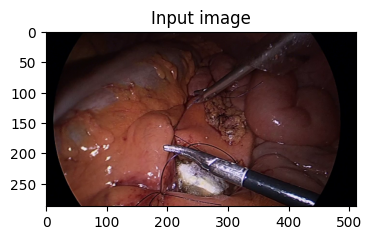

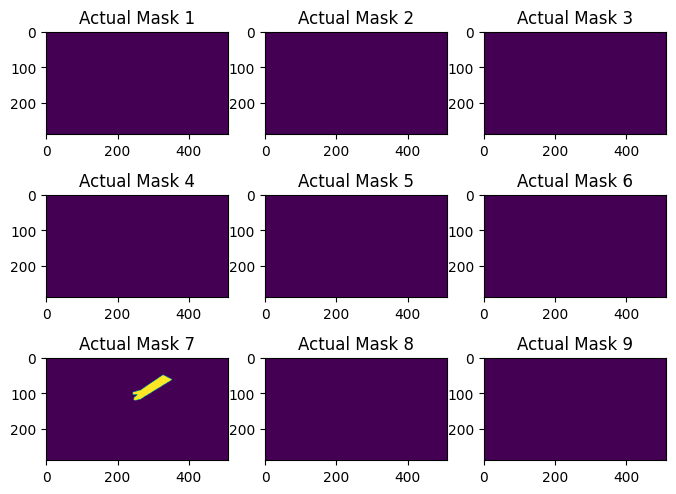

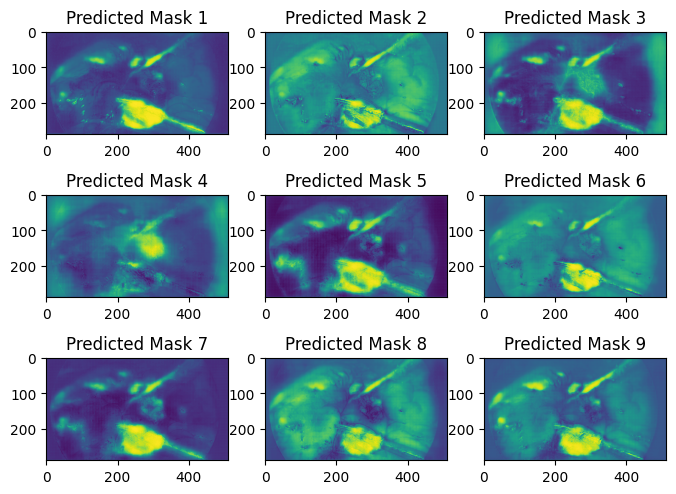

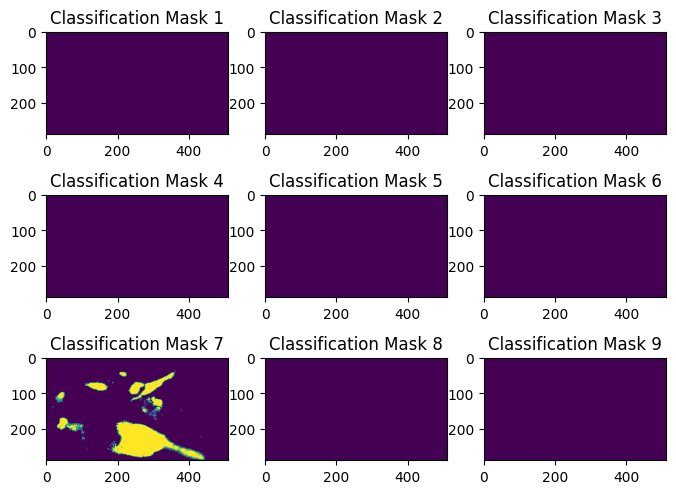

metrics: [0.4444444  0.92063491 0.68253968 0.34336943 0.54384203]
scores : 0.47903752230040336
real_score : 0.5993210868429748


In [ ]:
from IPython.display import clear_output

max_epochs = 50

# save loss values for plot
loss_history = []
metric_history = []
global_step = 0 # step 수 정의 (선택)
print_count = 10 # tf.gradient_tape
save_epochs = 5 # tf.gradient_tape
batch_step = (num_train_examples // batch_size) + (0 if num_train_examples % batch_size == 0 else 1)

for epoch in range(max_epochs):
    epoch_time = time.time()
    for filename, width, height, images, labels, cls in train_dataset: # 데이터 로드 파트
        start_time = time.time()
        global_step = global_step + 1
        
        with tf.GradientTape() as tape: # 모델 학습 파트
            predictions, pred_cls = model(images, training=True) # [batch_size, 256,256,3]
            #predictions = tf.expand_dims(tf.argmax(predictions,axis=-1),-1)
            loss = bce_dice_loss(labels, predictions) # label [batch_size, 256, 256, 1]
            loss = bce_dice_loss(labels, predictions * tf.reshape(tf.round(pred_cls),[pred_cls.shape[0],1,1,9]))
            loss += bce_loss(cls, pred_cls)
        # 가중치 업데이트 파트
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # 학습 상태 출력
        epochs = global_step * batch_size / float(num_train_examples)
        duration = time.time() - start_time

        if ((global_step % batch_step) % (batch_step//print_count)) == 0:
            clear_output(wait=True)
            
            print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.3f} sec/batch, {:.3f} sec/epoch)".format(
                        epochs, global_step, loss, duration, duration * batch_step * print_count))
            
            loss_history.append([epochs, loss])

            mean = []

            # print sample image                     
            for filename, width, height, test_images, test_labels, test_cls in test_dataset.take(1):
                sample = 2
                print(filename.numpy()[sample].decode('utf-8').rpartition('.')[0]+'.png')
                predictions, pred_cls = model(test_images, training=False)
                #predictions = tf.expand_dims(tf.argmax(predictions,axis=-1),-1)
                
                print('cls :', test_cls.numpy()[sample])
                print('pred :', pred_cls.numpy().round()[sample])
                plt.figure(figsize=(4, 3))
                plt.subplot(1, 1, 1)
                plt.imshow(test_images[sample,:,:,:])
                plt.title("Input image")
                plt.show()

                plt.figure(figsize=(8, 6))
                for i in range(9):
                    plt.subplot(3, 3, i+1)
                    plt.imshow(test_labels[sample,:,:,i])
                    plt.title("Actual Mask "+str(i+1))
                plt.show()

                plt.figure(figsize=(8, 6))
                for i in range(9):
                    plt.subplot(3, 3, i+1)
                    plt.imshow(predictions[sample,:,:,i])
                    plt.title("Predicted Mask "+str(i+1))
                plt.show()
                
                plt.figure(figsize=(8, 6))
                for i in range(9):
                    plt.subplot(3, 3, i+1)
                    plt.imshow(tf.round(predictions[sample,:,:,i]) * tf.round(pred_cls[sample,i]))
                    plt.title("Classification Mask "+str(i+1))
                plt.show()
                _, _, _, c_iou = metric_function(test_labels, test_cls, tf.round(predictions) * tf.reshape(tf.round(pred_cls),[pred_cls.shape[0],1,1,9]), pred_cls)
                
                sen, spe, m_auc, iou = metric_function(test_labels, test_cls, predictions, pred_cls)
                mean.append([sen, spe, m_auc, iou, c_iou])
                
            mean = np.array(mean)
            mean = np.mean(mean,axis=0)
            
            metric_history.append([epochs, mean[0], mean[1], mean[2], mean[3], mean[4]])
            
            score = mean[3]*0.6 + (mean[0]*0.1 + mean[1]*0.1 + mean[2]*0.2)
            real_score = mean[4]*0.6 + (mean[0]*0.1 + mean[1]*0.1 + mean[2]*0.2)
            print("metrics: {}".format(mean))
            print("scores : {}".format(score))
            print("real_score : {}".format(real_score))
            
    epoch_duration = time.time() - epoch_time
    print("Epoch Time :", epoch_duration)
    
    # saving (checkpoint) the model periodically
    if (epoch+1) % save_epochs == 0:
        checkpoint.save(checkpoint_prefix)

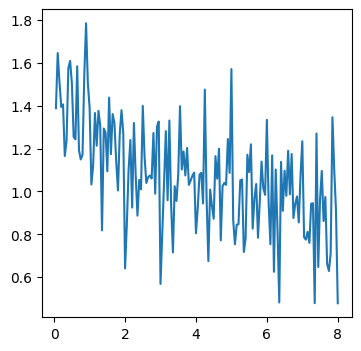

In [464]:
loss_history = np.asarray(loss_history)
plt.figure(figsize=(4, 4))
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()

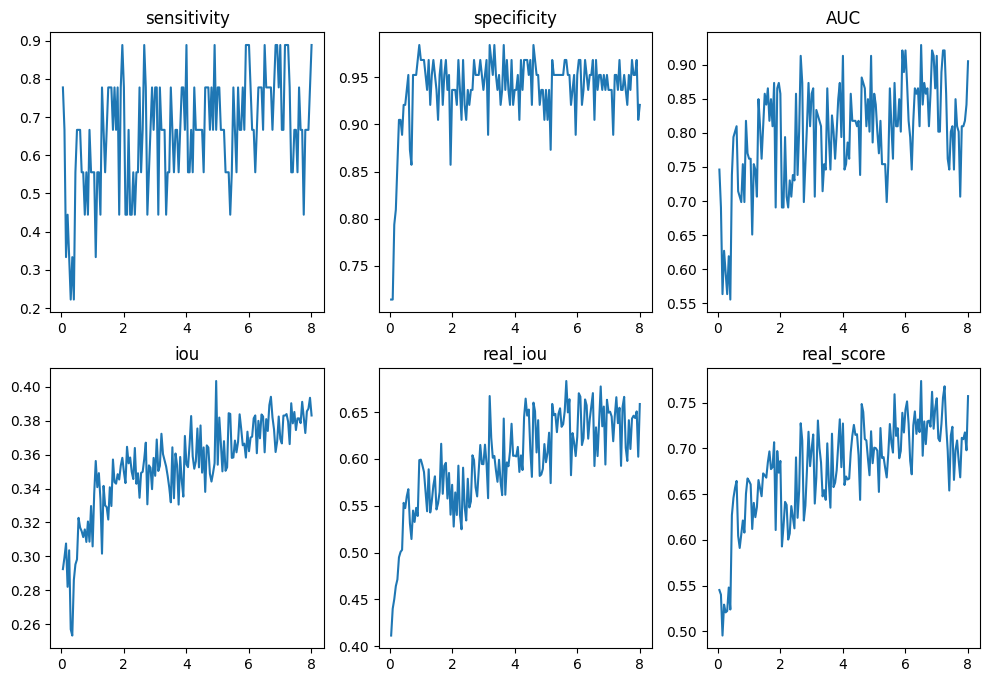

In [465]:
metric_history = np.asarray(metric_history)
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(metric_history[:,0], metric_history[:,1])
plt.title('sensitivity')

plt.subplot(2, 3, 2)
plt.plot(metric_history[:,0], metric_history[:,2])
plt.title('specificity')

plt.subplot(2, 3, 3)
plt.plot(metric_history[:,0], metric_history[:,3])
plt.title('AUC')

plt.subplot(2, 3, 4)
plt.plot(metric_history[:,0], metric_history[:,4])
plt.title('iou')

plt.subplot(2, 3, 5)
plt.plot(metric_history[:,0], metric_history[:,5])
plt.title('real_iou')

plt.subplot(2, 3, 6)
plt.plot(metric_history[:,0], metric_history[:,5]*0.6 + metric_history[:,1]*0.1 + metric_history[:,2]*0.1 + metric_history[:,3]*0.2)
plt.title('real_score')
plt.show()

In [466]:
import cv2
import pandas as pd

mean = []

# print sample image                     
for dsf, (filename, width, height, images, labels, cls) in enumerate(test_dataset):
    predictions, pred_cls = model(images, training=False)
    
    mask = np.zeros((predictions.shape[0],288,512,9))
    
    for sample in range(predictions.shape[0]):
        
        no_found = True
        for idx, img_cls in enumerate(pred_cls.numpy().round()[sample]):
            sample_label = predictions[sample].numpy().round()[:,:,idx]

            if(img_cls==1 and sample_label.sum()>1500):
                
                img = (sample_label*255).astype(np.uint8)
                
                contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                
                maximum = 0
                maximum_iter = 0
                for i, cnt in enumerate(contours):
                    if(maximum < cv2.contourArea(cnt)):
                        maximum = cv2.contourArea(cnt)
                        maximum_iter = i
                points = contours[maximum_iter]

                for i in range(100):
                    pl = cv2.approxPolyDP(points, (i/100)*cv2.arcLength(points, True), True)
                    if(pl.shape[0]<=10):
                        break
                pl = pl.squeeze()

                for i in range(10-len(pl)):
                    pl = np.concatenate((pl, pl[0].reshape(1,2)), axis=0)

                pl = [(x[0],x[1]) for x in pl]
                _img = Image.new('L', (512,288), 0)
                ImageDraw.Draw(_img).polygon(pl, outline=1, fill=1)
                mask[sample,:,:,idx] = np.array(_img)#tf.image.resize(np.expand_dims(np.array(_img), axis=-1),[288,512]).numpy().squeeze()

    sen, spe, m_auc, iou = metric_function(labels, cls, mask, tf.round(pred_cls).numpy())
    mean.append(sen*0.1 + spe*0.1 + m_auc*0.2 + iou*0.6)

    print('score :',sen*0.1 + spe*0.1 + m_auc*0.2 + iou*0.6)

score : 0.7944036682370734
score : 0.7058125441922608
score : 0.7465945562384393
score : 0.7481511479198373
score : 0.7225763569025949
score : 0.7625339850951218
score : 0.7519448123118585
score : 0.6478670447889852
score : 0.8361315099358066
score : 0.6443122752942508
score : 0.7858561972092591
score : 0.7686233971105846
score : 0.72845604067241
score : 0.7953704171086166
score : 0.6592373055680164
score : 0.8396848863219655
score : 0.7640538035863998
score : 0.8015447495040796
score : 0.633265708399636
score : 0.7384152794559006
score : 0.7511619208185287
score : 0.6716462453628309
score : 0.748591758312477
score : 0.6736063335873947
score : 0.743597331194102
score : 0.6874117318483781
score : 0.6765879574436657
score : 0.9159103395835979
score : 0.7685375446475226
score : 0.8253996326860646
score : 0.6492822213028795
score : 0.8051477715486781
score : 0.6322465047226962
score : 0.7786249791839598
score : 0.7749856036517202
score : 0.8300444484819497
score : 0.7118534456139807
score 

In [467]:
#테스트 스코어
np.mean(np.array(mean))

0.7342915981553414

In [468]:
inference_list = os.listdir(inference_data)
inference_list.sort()
inference_list

['img_00001.png',
 'img_00002.png',
 'img_00003.png',
 'img_00004.png',
 'img_00005.png',
 'img_00006.png',
 'img_00007.png',
 'img_00008.png',
 'img_00009.png',
 'img_00010.png',
 'img_00011.png',
 'img_00012.png',
 'img_00013.png',
 'img_00014.png',
 'img_00015.png',
 'img_00016.png',
 'img_00017.png',
 'img_00018.png',
 'img_00019.png',
 'img_00020.png',
 'img_00021.png',
 'img_00022.png',
 'img_00023.png',
 'img_00024.png',
 'img_00025.png',
 'img_00026.png',
 'img_00027.png',
 'img_00028.png',
 'img_00029.png',
 'img_00030.png',
 'img_00031.png',
 'img_00032.png',
 'img_00033.png',
 'img_00034.png',
 'img_00035.png',
 'img_00036.png',
 'img_00037.png',
 'img_00038.png',
 'img_00039.png',
 'img_00040.png',
 'img_00041.png',
 'img_00042.png',
 'img_00043.png',
 'img_00044.png',
 'img_00045.png',
 'img_00046.png',
 'img_00047.png',
 'img_00048.png',
 'img_00049.png',
 'img_00050.png',
 'img_00051.png',
 'img_00052.png',
 'img_00053.png',
 'img_00054.png',
 'img_00055.png',
 'img_0005

In [469]:
def _process_inference(filename):
    # We map this function onto each pathname pair
    img_path = inference_data+'/'+filename
    
    img_str = tf.io.read_file(img_path)
    img = tf.image.decode_png(img_str, channels=3) # RGB
    
    width = tf.cast(img.shape[0], dtype=tf.uint16)
    height = tf.cast(img.shape[1], dtype=tf.uint16)
    
    resize = [288, 512]
    img = tf.image.resize(img, resize)
    
    scale = 1 / 255.                
    img = tf.cast(img, dtype=tf.float32) * scale
    filename = tf.cast(filename, dtype=tf.string)
    
    return filename, width, height, img

In [470]:

def gen_infer():
    for i in inference_list:
        yield _process_inference(i)
    
def dataset_infer(batch_size=8):
    
    dataset = tf.data.Dataset.from_generator(gen_infer, (tf.string, tf.uint16, tf.uint16, tf.float32), ((), (), (), (288,512,3)))
    
    dataset = dataset.batch(batch_size)
    return dataset



In [471]:
infer_dataset = dataset_infer()

In [472]:
import cv2
import pandas as pd

results = pd.DataFrame(columns=['file', 'class', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10'])
count = 0

# print sample image                     
for filename, width, height, images in infer_dataset:
    predictions, pred_cls = model(images, training=False)
    for sample in range(predictions.shape[0]):
        no_found = True
        for idx, img_cls in enumerate(pred_cls.numpy().round()[sample]):
            sample_label = predictions[sample].numpy().round()[:,:,idx]
            if(img_cls==1 and sample_label.sum()>300):
                img = tf.image.resize(np.expand_dims(sample_label, axis=-1), [width.numpy()[sample], height.numpy()[sample]])
                img = img.numpy()
                img = (img*255).astype(np.uint8)
                
                contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                
                maximum = 0
                maximum_iter = 0
                for i, cnt in enumerate(contours):
                    if(maximum < cv2.contourArea(cnt)):
                        maximum = cv2.contourArea(cnt)
                        maximum_iter = i
                points = contours[maximum_iter]

                for i in range(100):
                    pl = cv2.approxPolyDP(points, (i/100)*cv2.arcLength(points, True), True)
                    if(pl.shape[0]<=10):
                        break
                pl = pl.squeeze()

                for i in range(10-len(pl)):
                    pl = np.concatenate((pl, pl[0].reshape(1,2)), axis=0)
                pl = pl.flatten()
                result = [filename.numpy()[sample].decode('utf-8').rpartition('.')[0], idx]
                result.extend(pl)
                
                results.loc[count] = result
                no_found = False
                count += 1
        if(no_found):
            result = [filename.numpy()[sample].decode('utf-8').rpartition('.')[0]]
            result.extend([None] * 21)
            results.loc[count] = result
            count += 1

In [473]:
results

,file,class,x1,y1,x2,y2,x3,y3,x4,y4,...,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10
0,img_00001,2,598,695,469,720,383,830,221,862,...,375,954,396,879,520,847,598,695,598,695
1,img_00002,5,9,919,28,631,831,492,957,541,...,24,328,365,115,0,39,9,919,9,919
2,img_00003,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,img_00004,1,729,357,1278,961,1278,624,729,357,...,729,357,729,357,729,357,729,357,729,357
4,img_00004,4,545,784,446,752,234,982,375,961,...,483,911,545,784,545,784,545,784,545,784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,img_01376,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1782,img_01377,0,1299,494,1337,500,1326,578,1787,740,...,1919,698,1898,591,1722,538,1573,542,1456,493
1783,img_01378,1,921,684,1442,878,1584,762,1917,1055,...,1854,824,1257,594,921,684,921,684,921,684
1784,img_01379,0,6,294,0,338,39,383,95,375,...,207,413,132,321,6,294,6,294,6,294


In [474]:
results.to_csv('results.csv',index = False)